In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from itertools import product
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import itertools
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import statsmodels.api as sm
%matplotlib inline
# Ignore warnings
warnings.filterwarnings("ignore")

In [2]:
df_playstore = pd.read_csv('googleplaystore.csv')
print('Shape before checking for duplicates: {}'.format(df_playstore.shape))
df_playstore = df_playstore.drop_duplicates()
print('Shape after checking for duplicates: {}'.format(df_playstore.shape))

Shape before checking for duplicates: (10841, 13)
Shape after checking for duplicates: (10358, 13)


In [3]:
df_playstore = df_playstore.drop(['Genres', 'Last Updated', 'Current Ver'], axis=1)

In [4]:
df_playstore  = df_playstore.loc[df_playstore['Reviews'] != '3.0M']
df_playstore = df_playstore.astype({'Reviews': int})

In [5]:
df_playstore_rating_median = df_playstore.loc[~df_playstore['Rating'].isnull()]
df_playstore_rating_median = df_playstore.groupby('Category').agg(
                                median_rating = pd.NamedAgg(column='Rating', aggfunc='median'))

def null_rating(row):
    rating, category = row
    if str(rating) in ('NaN', 'nan'):
        rating = float(df_playstore_rating_median.loc[category].values)
    else:
        rating = rating
    
    return rating

df_playstore['Rating'] = df_playstore[['Rating', 'Category']].apply(tuple, axis=1)
df_playstore['Rating'] = df_playstore['Rating'].apply(lambda row: null_rating(row))

In [6]:
def size_to_bytes(data, lookup_table={}):
    if type(data) != tuple:
        if data != 'Varies with device':
            size = data
            size = list(size)
            if size[-1] in ('M', 'm'):
                size = "".join(size[:-1])
                size = float(size)
                size = size * 1024 * 1024 * 8
            elif size[-1] in ('K', 'k'):
                size = "".join(size[:-1])
                size = float(size)
                size = size * 1024 * 8
            else:
                size = size
            return size
        else:
            return data
    
    elif type(data) == tuple:
        size, category = data
        if size == 'Varies with device':
            size = lookup_table.loc[category].values
        else:
            size = size
        return size

df_playstore['Size'] = df_playstore['Size'].apply(lambda row: size_to_bytes(row))
lookup_table = df_playstore.loc[df_playstore['Size'] != 'Varies with device']
lookup_table = lookup_table.groupby('Category').agg(
                mean_size = pd.NamedAgg(column='Size', aggfunc='mean'))
df_playstore['Size'] = df_playstore[['Size', 'Category']].apply(tuple, axis=1)
df_playstore['Size'] = df_playstore['Size'].apply(lambda row: size_to_bytes(row, lookup_table))
df_playstore = df_playstore.astype({'Size': int})

In [7]:
df_playstore['Free'] = [1 if type=='Free' else 0 for type in df_playstore['Type']]
df_playstore['Paid'] = [1 if type=='Paid' else 0 for type in df_playstore['Type']]
df_playstore = df_playstore.drop('Type', axis=1)

In [8]:
df_playstore['Content Rating'] = [1 if content_rating=='Everyone' else 0 for content_rating in df_playstore['Content Rating']]

In [9]:
def price(row):
    if row==0:
        return row
    else:
        row = str(row)
        row = row.split('$')[-1]
        return float(row)

df_playstore['Price'] = df_playstore['Price'].apply(lambda row: price(row))
df_playstore = df_playstore.astype({'Price': float})

In [10]:
def android_version(data, lookup_table={}):
    if type(data) != tuple:
        version = data
        if version != 'Varies with device':
            version = str(version)
            return version.split(" ")[0]
        else:
            return version
    
    elif type(data) == tuple:
        version, category = data
        if str(version) in ('Varies with device', 'nan', 'NAN', 'NaN'):
            version = lookup_table.loc[category].values
            if type(version) == np.ndarray:
                version = version[0][0]
            else:
                version = version
        else:
            version = version
    
        version = str(version)
        version = version[:3]
        version =float(version)
        return version
        

df_playstore['Android Ver'] = df_playstore['Android Ver'].apply(lambda row: android_version(row))
lookup_table = df_playstore.loc[df_playstore['Android Ver'] != 'Varies with device']
lookup_table = lookup_table.groupby('Category').agg(
                mode_version = pd.NamedAgg(column='Android Ver', aggfunc=pd.Series.mode))
df_playstore['Android Ver'] = df_playstore[['Android Ver', 'Category']].apply(tuple, axis=1)
df_playstore['Android Ver'] = df_playstore['Android Ver'].apply(lambda row: android_version(row, lookup_table))
df_playstore = df_playstore.astype({'Android Ver': float})

In [11]:
df_playstore = df_playstore.drop('App', axis=1)

In [12]:
# Define the logical bins and their corresponding categories
logical_bins = {
    '1': ['ART_AND_DESIGN', 'COMICS', 'PHOTOGRAPHY', 'VIDEO_PLAYERS'],
    '2': ['AUTO_AND_VEHICLES', 'TOOLS', 'MAPS_AND_NAVIGATION', 'TRAVEL_AND_LOCAL'],
    '3': ['BEAUTY', 'FASHION', 'LIFESTYLE'],
    '4': ['BOOKS_AND_REFERENCE', 'EDUCATION', 'LIBRARIES_AND_DEMO'],
    '5': ['BUSINESS', 'FINANCE', 'PRODUCTIVITY'],
    '6': ['COMMUNICATION', 'SOCIAL', 'DATING'],
    '7': ['ENTERTAINMENT', 'EVENTS', 'GAME'],
    '8': ['FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'SPORTS', 'MEDICAL'],
    '9': ['HOUSE_AND_HOME', 'PARENTING', 'WEATHER', 'FAMILY'],
    '10': ['NEWS_AND_MAGAZINES', 'SHOPPING', 'PERSONALIZATION']
}

# Function to map categories to logical bins
def map_to_bin(category):
    for bin_name, bin_categories in logical_bins.items():
        if category in bin_categories:
            return bin_name
    return None  # If category is not found in any bin

# Create a new column 'logical_bin' to store the mapped bins
df_playstore['logical_bin'] = df_playstore['Category'].apply(map_to_bin)


In [13]:
# Convert installs to numeric values
df_playstore['Installs'] = df_playstore['Installs'].str.replace('[+,]', '', regex=True).astype(int)

# Define custom bins for categories
bins = [0, 500, 10000, 100000, 1000000, 10000000, 1000000001]

# Define labels for each bin
labels = [0, 1, 2, 3, 4, 5]

# Cut the data into the custom categories
df_playstore['installs_category'] = pd.cut(df_playstore['Installs'], bins=bins, labels=labels, right=False)

In [14]:
df_playstore.drop(columns=['Installs', 'Category'], inplace=True)

In [15]:
# Splitting data into X and y datasets based on the target variable
X = df_playstore.drop('installs_category', axis=1)
y = df_playstore['installs_category']

from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object and fit_transform the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(X)

# Convert the normalized data back to a DataFrame
X = pd.DataFrame(normalized_data, columns=X.columns)

In [16]:
# Split the dataset into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.3, random_state=42)

In [17]:
# Import necessary libraries
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define parameter combinations for each model
k_values = range(1, 51)  # Number of neighbors (k) to consider, from 1 to 50
knn_params = k_values

# Set random seed for reproducibility
np.random.seed(42)

# Initialize lists to store accuracy, precision, and recall values
accuracies = []
precisions = []
recalls = []

# Perform k-fold cross-validation for parameter combinations
for k in knn_params:
    print("Testing parameter combination: k={}".format(k))

    # Create the KNN Classifier
    model = KNeighborsClassifier(n_neighbors=k)

    # Perform k-fold cross-validation and get accuracy, precision, and recall scores
    cv_scores_accuracy = cross_val_score(
        model, X_train, y_train, cv=5)
    cv_scores_precision = cross_val_score(model, X_train, y_train, cv=5, scoring='precision_macro')
    cv_scores_recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall_macro')


    # Calculate mean scores for accuracy, precision, and recall
    accuracy = np.mean(cv_scores_accuracy)
    precision = np.mean(cv_scores_precision)
    recall = np.mean(cv_scores_recall)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

    print("Cross-Validation Accuracy:", accuracy)
    print("Cross-Validation Precision:", precision)
    print("Cross-Validation Recall:", recall)
    print()

# Find the best hyperparameter based on the validation set performance
best_k = knn_params[np.argmax(accuracies)]
print("Best k:", best_k)

# Train the final model using the best hyperparameter on the training set
final_model = KNeighborsClassifier(n_neighbors=best_k)
final_model.fit(X_train, y_train)

# Make predictions on the testing set
y_test_pred = final_model.predict(X_test)

# Calculate accuracy, precision, and recall on the testing set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')  # For multiclass use 'macro' average
recall = recall_score(y_test, y_test_pred, average='macro')  # For multiclass use 'macro' average

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)


Testing parameter combination: k=1
Cross-Validation Accuracy: 0.3823068340721788
Cross-Validation Precision: 0.3797918705209034
Cross-Validation Recall: 0.3750755086247581

Testing parameter combination: k=2
Cross-Validation Accuracy: 0.34833715152777367
Cross-Validation Precision: 0.3911136358607892
Cross-Validation Recall: 0.35449987821843826

Testing parameter combination: k=3
Cross-Validation Accuracy: 0.36713456903989766
Cross-Validation Precision: 0.38024672689079325
Cross-Validation Recall: 0.3690007576482647

Testing parameter combination: k=4
Cross-Validation Accuracy: 0.3702374222724703
Cross-Validation Precision: 0.3701408128965158
Cross-Validation Recall: 0.36741666383720895

Testing parameter combination: k=5
Cross-Validation Accuracy: 0.3723074291154681
Cross-Validation Precision: 0.3736023064387136
Cross-Validation Recall: 0.36908500042372283

Testing parameter combination: k=6
Cross-Validation Accuracy: 0.36937639463270955
Cross-Validation Precision: 0.37402261884325677

In [18]:
# Make probability predictions on the validation set
y_val_pred = final_model.predict(X_val)

# Calculate accuracy, precision, and recall on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')

print("Validation Accuracy:", accuracy)
print("Validation Precision:", precision)
print("Validation Recall:", recall)

Validation Accuracy: 0.3821399839098954
Validation Precision: 0.3991966560665586
Validation Recall: 0.40217550547268693


In [19]:
# Calculate accuracy, precision, and recall on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro')
test_recall = recall_score(y_test, y_test_pred, average='macro')

print("Final Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Final Test Accuracy: 0.4078185328185328
Test Precision: 0.3991966560665586
Test Recall: 0.40217550547268693


Confusion Matrix:


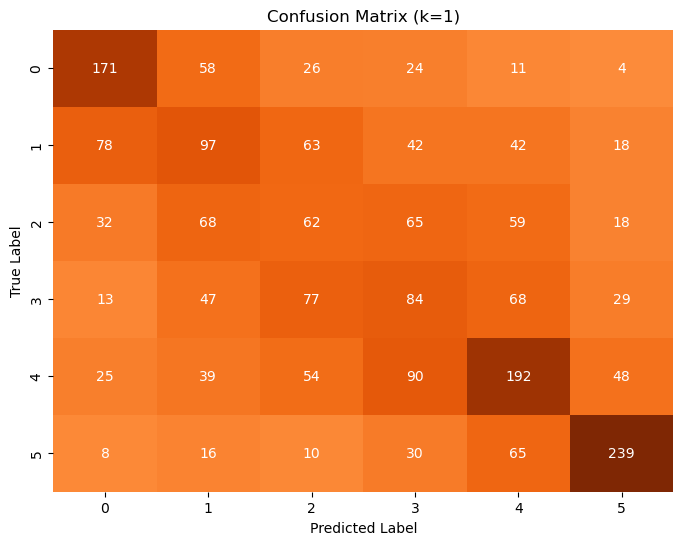

In [20]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False, center=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (k={})".format(best_k))
plt.show()

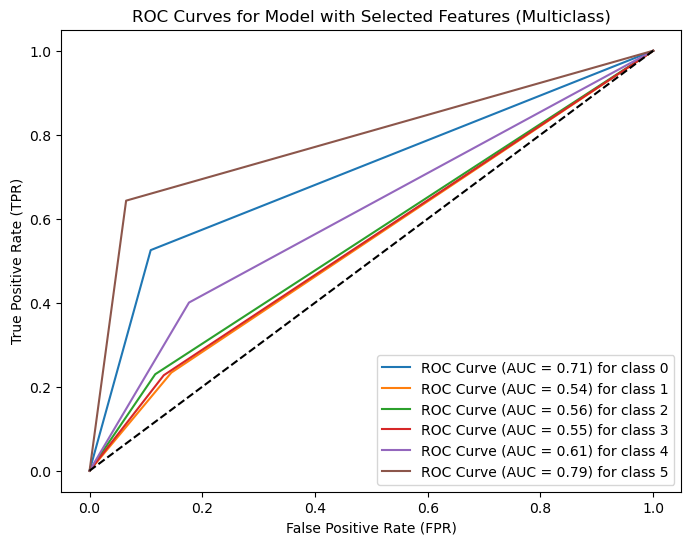

In [21]:
from sklearn.preprocessing import LabelEncoder, label_binarize

# Step 1: Label encode the target variable for both training and validation sets
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Make predictions on the validation set
y_val_prob = final_model.predict_proba(X_val)

# Binarize the labels for the multiclass ROC curve
y_val_binarized = label_binarize(y_val_encoded, classes=np.arange(len(label_encoder.classes_)))

# Compute the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_idx in range(len(label_encoder.classes_)):
    fpr[class_idx], tpr[class_idx], _ = roc_curve(y_val_binarized[:, class_idx], y_val_prob[:, class_idx])
    roc_auc[class_idx] = roc_auc_score(y_val_binarized[:, class_idx], y_val_prob[:, class_idx])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for class_idx in range(len(label_encoder.classes_)):
    plt.plot(fpr[class_idx], tpr[class_idx], label='ROC Curve (AUC = {:.2f}) for class {}'.format(
        roc_auc[class_idx], label_encoder.classes_[class_idx]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Model with Selected Features (Multiclass)')
plt.legend()
plt.show()

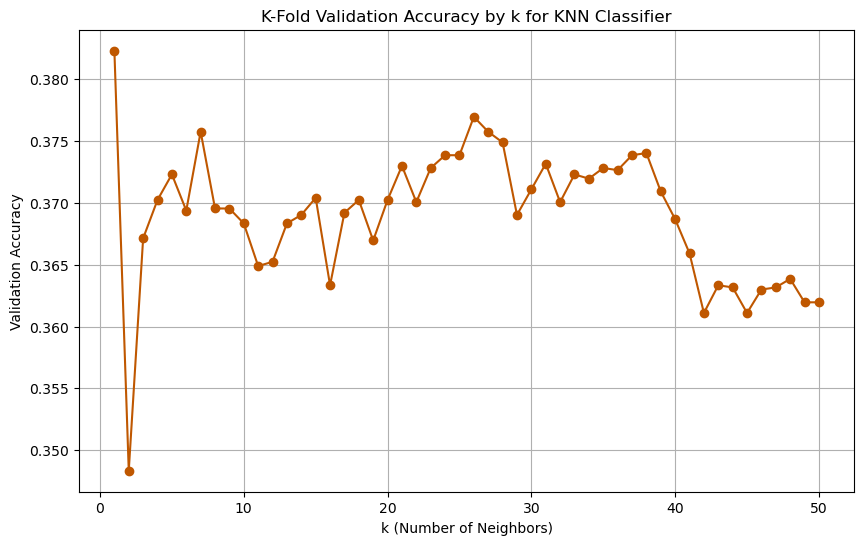

In [22]:
# Generate line graph of all iterations
plt.figure(figsize=(10, 6))
plt.plot(knn_params, accuracies, marker='o', color='#BF5700')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Validation Accuracy')
plt.title('K-Fold Validation Accuracy by k for KNN Classifier')
plt.grid()
plt.show()

In [24]:
# Define parameter combinations for each model
# Number of base estimators (trees)
bagging_n_estimators = [*range(5, 150, 15)]

# Set random seed for reproducibility
np.random.seed(42)

# Initialize lists to store accuracy, precision, and recall values
accuracies = []
precisions = []
recalls = []

# Perform k-fold cross-validation for parameter combinations
for n_estimators in bagging_n_estimators:
    print("Testing parameter combination: n_estimators={}".format(n_estimators))

    # Create the Bagging Classifier with DecisionTree base estimator
    # Base estimator: DecisionTreeClassifier
    base_estimator = DecisionTreeClassifier(max_depth=5, random_state=42)
    model = BaggingClassifier(base_estimator=base_estimator,
                              n_estimators=n_estimators, random_state=42)

    # Perform k-fold cross-validation and get accuracy, precision, and recall scores
    cv_scores_accuracy = cross_val_score(
        model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_precision = cross_val_score(
        model, X_train, y_train, cv=5, scoring='precision_macro')  # For multiclass use 'precision_macro'
    cv_scores_recall = cross_val_score(
        model, X_train, y_train, cv=5, scoring='recall_macro')  # For multiclass use 'recall_macro'

    # Calculate mean scores for accuracy, precision, and recall
    accuracy = np.mean(cv_scores_accuracy)
    precision = np.mean(cv_scores_precision)
    recall = np.mean(cv_scores_recall)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

    print("Cross-Validation Accuracy:", accuracy)
    print("Cross-Validation Precision:", precision)
    print("Cross-Validation Recall:", recall)
    print()

# Find the best hyperparameter based on the cross-validation performance
best_params_idx = np.argmax(accuracies)
best_n_estimators = bagging_n_estimators[np.argmax(accuracies)]
print("Best n_estimators:", best_n_estimators)

# Train the final model using the best hyperparameter on the full training set
final_model = BaggingClassifier(base_estimator=base_estimator,
                                n_estimators=best_n_estimators, random_state=42)
final_model.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = final_model.predict(X_val)

# Calculate accuracy, precision, and recall on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='macro')  # For multiclass use 'macro' average
recall = recall_score(y_val, y_val_pred, average='macro')  # For multiclass use 'macro' average

print("Validation Accuracy:", accuracy)
print("Validation Precision:", precision)
print("Validation Recall:", recall)


Testing parameter combination: n_estimators=5
Cross-Validation Accuracy: 0.7784052839844099
Cross-Validation Precision: 0.7785281572069268
Cross-Validation Recall: 0.7764740384078241

Testing parameter combination: n_estimators=20
Cross-Validation Accuracy: 0.7808193746095029
Cross-Validation Precision: 0.7807831003042341
Cross-Validation Recall: 0.7789647232046555

Testing parameter combination: n_estimators=35
Cross-Validation Accuracy: 0.7811644997173544
Cross-Validation Precision: 0.7812056490610305
Cross-Validation Recall: 0.7794511276867774

Testing parameter combination: n_estimators=50
Cross-Validation Accuracy: 0.7820264199220494
Cross-Validation Precision: 0.7817266534884706
Cross-Validation Recall: 0.7803161708445774

Testing parameter combination: n_estimators=65
Cross-Validation Accuracy: 0.7821991312367975
Cross-Validation Precision: 0.7819681763989513
Cross-Validation Recall: 0.7805150276665972

Testing parameter combination: n_estimators=80
Cross-Validation Accuracy: 0.

In [25]:
# Make probability predictions on the testing set
y_test_pred = final_model.predict(X_test)

# Calculate accuracy, precision, and recall on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro')
test_recall = recall_score(y_test, y_test_pred, average='macro')

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Test Accuracy: 0.76496138996139
Test Precision: 0.7640774702483205
Test Recall: 0.7611318439159841


Confusion Matrix:


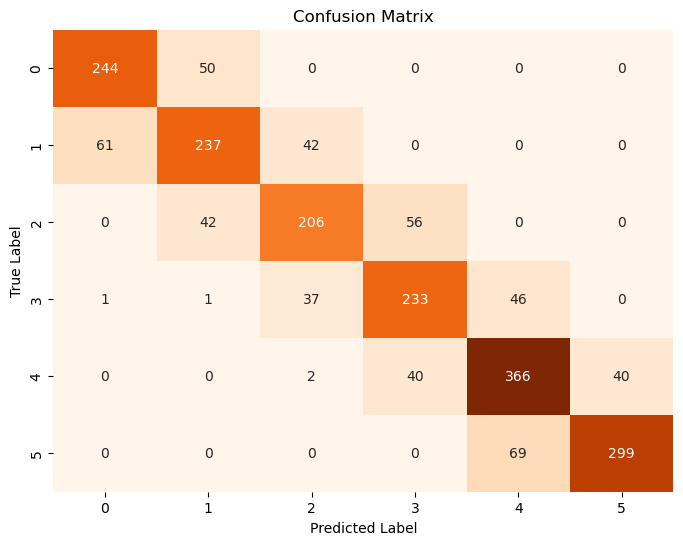

In [26]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

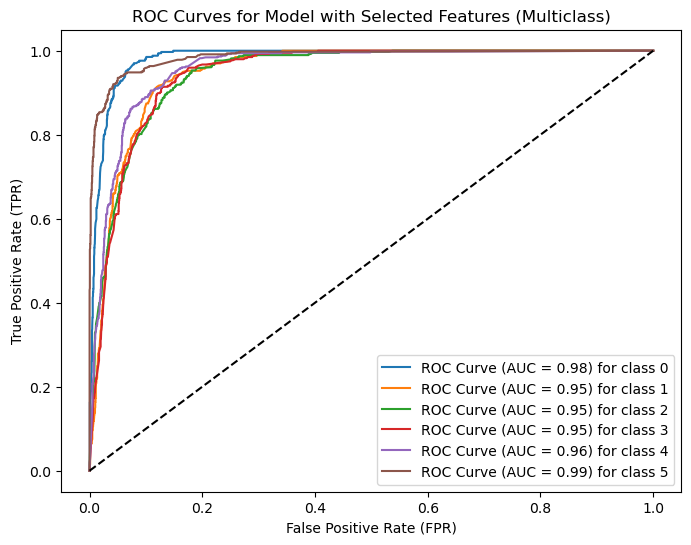

In [27]:
from sklearn.preprocessing import LabelEncoder, label_binarize

# Step 1: Label encode the target variable for both training and validation sets
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Make predictions on the validation set
y_val_prob = final_model.predict_proba(X_val)

# Binarize the labels for the multiclass ROC curve
y_val_binarized = label_binarize(y_val_encoded, classes=np.arange(len(label_encoder.classes_)))

# Compute the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_idx in range(len(label_encoder.classes_)):
    fpr[class_idx], tpr[class_idx], _ = roc_curve(y_val_binarized[:, class_idx], y_val_prob[:, class_idx])
    roc_auc[class_idx] = roc_auc_score(y_val_binarized[:, class_idx], y_val_prob[:, class_idx])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for class_idx in range(len(label_encoder.classes_)):
    plt.plot(fpr[class_idx], tpr[class_idx], label='ROC Curve (AUC = {:.2f}) for class {}'.format(
        roc_auc[class_idx], label_encoder.classes_[class_idx]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Model with Selected Features (Multiclass)')
plt.legend()
plt.show()

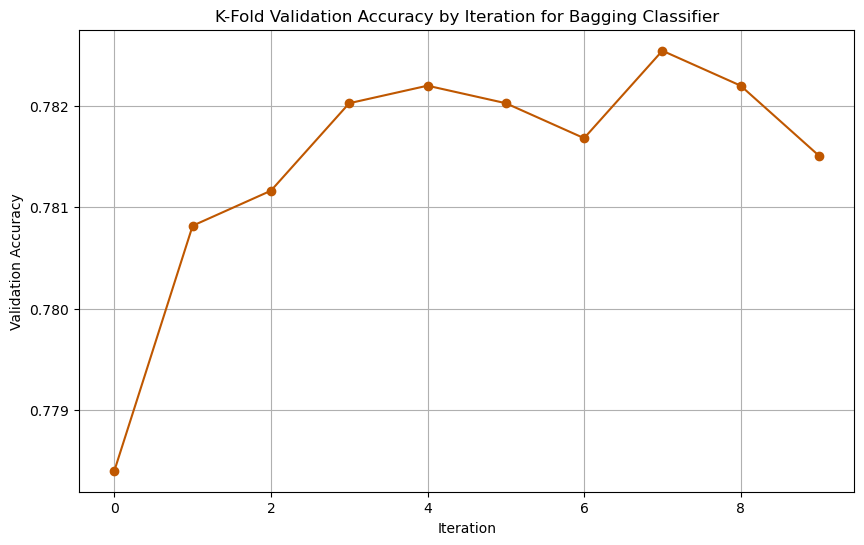

In [28]:
# Generate line graph of all iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracies)), accuracies, marker='o', color='#BF5700')
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.title('K-Fold Validation Accuracy by Iteration for Bagging Classifier')
plt.grid()
plt.show()

In [29]:
# Import necessary libraries
import numpy as np
from itertools import product
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

# Define parameter combinations for each model
gb_n_estimators = [50, 100]
gb_learning_rate = [0.01, 0.1]
dt_max_depth = [2, 5]
gb_params = list(product(gb_n_estimators, gb_learning_rate, dt_max_depth))

# Set random seed for reproducibility
np.random.seed(42)

# Initialize lists to store accuracy, precision, and recall values
accuracies = []
precisions = []
recalls = []

# Perform k-fold cross-validation for parameter combinations
k_folds = 5
cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

for params in gb_params:
    n_estimators, learning_rate, max_depth = params
    print("Testing parameter combination: n_estimators={}, learning_rate={}, max_depth={}".format(
        n_estimators, learning_rate, max_depth))

    # Create the Gradient Boosting classifier
    model = GradientBoostingClassifier(
        n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)

    # Perform k-fold cross-validation and get accuracy, precision, and recall scores
    cv_scores_accuracy = cross_val_score(
        model, X_train, y_train, cv=cv, scoring='accuracy')
    cv_scores_precision = cross_val_score(
        model, X_train, y_train, cv=cv, scoring='precision_macro')  # For multiclass use 'precision_macro'
    cv_scores_recall = cross_val_score(
        model, X_train, y_train, cv=cv, scoring='recall_macro')  # For multiclass use 'recall_macro'

    # Calculate mean scores for accuracy, precision, and recall
    accuracy = np.mean(cv_scores_accuracy)
    precision = np.mean(cv_scores_precision)
    recall = np.mean(cv_scores_recall)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

    print("Cross-Validation Accuracy:", accuracy)
    print("Cross-Validation Precision:", precision)
    print("Cross-Validation Recall:", recall)
    print()

# Find the best hyperparameters based on the validation set performance
best_params_idx = np.argmax(accuracies)
best_params = gb_params[best_params_idx]
best_n_estimators, best_learning_rate, best_max_depth = best_params
print("Best hyperparameters: n_estimators={}, learning_rate={}, max_depth={}".format(
    best_n_estimators, best_learning_rate, best_max_depth))

# Train the final model using the best hyperparameters on the full training set
final_model = GradientBoostingClassifier(
    n_estimators=best_n_estimators, learning_rate=best_learning_rate, max_depth=best_max_depth, random_state=42)
final_model.fit(X_train, y_train)

# Make probability predictions on the validation set
y_val_prob = final_model.predict_proba(X_val)

# Get the predicted class labels directly without using a threshold
y_val_pred = final_model.predict(X_val)

# Calculate accuracy, precision, and recall on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='macro')  # For multiclass use 'macro' average
recall = recall_score(y_val, y_val_pred, average='macro')  # For multiclass use 'macro' average

print("Validation Accuracy:", accuracy)
print("Validation Precision:", precision)
print("Validation Recall:", recall)


Testing parameter combination: n_estimators=50, learning_rate=0.01, max_depth=2
Cross-Validation Accuracy: 0.7353018357085478
Cross-Validation Precision: 0.740014514887241
Cross-Validation Recall: 0.7253765233052955

Testing parameter combination: n_estimators=50, learning_rate=0.01, max_depth=5
Cross-Validation Accuracy: 0.7775497604950761
Cross-Validation Precision: 0.7775883587863487
Cross-Validation Recall: 0.7745854507211125

Testing parameter combination: n_estimators=50, learning_rate=0.1, max_depth=2
Cross-Validation Accuracy: 0.7778948856029275
Cross-Validation Precision: 0.7768518997594996
Cross-Validation Recall: 0.7761478112233607

Testing parameter combination: n_estimators=50, learning_rate=0.1, max_depth=5


In [ ]:
# Get the predicted class labels directly without using a threshold
y_test_pred = final_model.predict(X_test)

# Calculate accuracy, precision, and recall on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro')  # For multiclass use 'macro' average
test_recall = recall_score(y_test, y_test_pred, average='macro')  # For multiclass use 'macro' average

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

In [ ]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder, label_binarize

# Step 1: Label encode the target variable for both training and validation sets
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Make predictions on the validation set
y_val_prob = final_model.predict_proba(X_val)

# Binarize the labels for the multiclass ROC curve
y_val_binarized = label_binarize(y_val_encoded, classes=np.arange(len(label_encoder.classes_)))

# Compute the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_idx in range(len(label_encoder.classes_)):
    fpr[class_idx], tpr[class_idx], _ = roc_curve(y_val_binarized[:, class_idx], y_val_prob[:, class_idx])
    roc_auc[class_idx] = roc_auc_score(y_val_binarized[:, class_idx], y_val_prob[:, class_idx])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for class_idx in range(len(label_encoder.classes_)):
    plt.plot(fpr[class_idx], tpr[class_idx], label='ROC Curve (AUC = {:.2f}) for class {}'.format(
        roc_auc[class_idx], label_encoder.classes_[class_idx]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Model with Selected Features (Multiclass)')
plt.legend()
plt.show()

In [ ]:
# Generate line graph of all iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracies)), accuracies,
         marker='o', label='Validation Accuracy', color='#BF5700')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('K-Fold Validation Accuracy by Iteration')
plt.legend()
plt.show()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from statsmodels.discrete.discrete_model import Logit

# Assuming you have already defined X_train, y_train, X_val, and y_val

# Set the number of folds for cross-validation
k_folds = 5
cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store performance metrics for each fold
train_accuracies = []
val_accuracies = []
val_precisions = []
val_recalls = []

for fold_idx, (train_index, val_index) in enumerate(cv.split(X_train, y_train)):
    # Create and train the initial Logistic Regression model on the training data
    initial_logit_model = LogisticRegression(random_state=42, max_iter=1000)
    initial_logit_model.fit(X_train.iloc[train_index], y_train.iloc[train_index])

    # Print accuracies for the initial model on the training and validation sets
    initial_train_pred = initial_logit_model.predict(X_train.iloc[train_index])
    initial_train_accuracy = accuracy_score(y_train.iloc[train_index], initial_train_pred)

    initial_val_pred = initial_logit_model.predict(X_train.iloc[val_index])
    initial_val_accuracy = accuracy_score(y_train.iloc[val_index], initial_val_pred)
    initial_val_precision = precision_score(y_train.iloc[val_index], initial_val_pred, average='macro')  # For multiclass use 'macro' average
    initial_val_recall = recall_score(y_train.iloc[val_index], initial_val_pred, average='macro')  # For multiclass use 'macro' average

    # Store the metrics for each fold
    train_accuracies.append(initial_train_accuracy)
    val_accuracies.append(initial_val_accuracy)
    val_precisions.append(initial_val_precision)
    val_recalls.append(initial_val_recall)

# Print average performance metrics across all folds
print('\n', "Initial Model - Cross-validation Results:")
print("Average Training Accuracy:", np.mean(train_accuracies))
print("Average Validation Accuracy:", np.mean(val_accuracies))
print("Average Precision:", np.mean(val_precisions))
print("Average Recall:", np.mean(val_recalls))


 Initial Model - Cross-validation Results:
Average Training Accuracy: 0.4019229582772744
Average Validation Accuracy: 0.3981742584273006
Average Precision: 0.4097856954218613
Average Recall: 0.36721198039781755


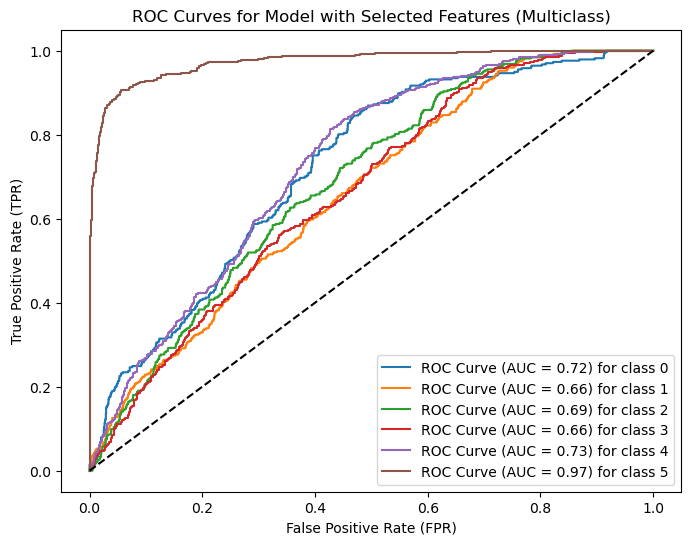

In [18]:
from sklearn.preprocessing import LabelEncoder, label_binarize

# Step 1: Label encode the target variable for both training and validation sets
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Make predictions on the validation set
y_val_prob = initial_logit_model.predict_proba(X_val)

# Binarize the labels for the multiclass ROC curve
y_val_binarized = label_binarize(y_val_encoded, classes=np.arange(len(label_encoder.classes_)))

# Compute the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_idx in range(len(label_encoder.classes_)):
    fpr[class_idx], tpr[class_idx], _ = roc_curve(y_val_binarized[:, class_idx], y_val_prob[:, class_idx])
    roc_auc[class_idx] = roc_auc_score(y_val_binarized[:, class_idx], y_val_prob[:, class_idx])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for class_idx in range(len(label_encoder.classes_)):
    plt.plot(fpr[class_idx], tpr[class_idx], label='ROC Curve (AUC = {:.2f}) for class {}'.format(
        roc_auc[class_idx], label_encoder.classes_[class_idx]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Model with Selected Features (Multiclass)')
plt.legend()
plt.show()

In [20]:
initial_logit_model.coef_

array([[ 4.70659694e-01, -5.10122212e+00, -3.29926310e-01,
         1.93051096e-01,  9.15873169e-02,  8.10263922e-02,
        -1.86127771e-01,  1.86225744e-01,  7.51704644e-02],
       [-1.91930304e-01, -5.05881702e+00, -3.51654692e-01,
         1.95555804e-01,  1.93218706e-01,  6.78083935e-03,
        -1.94876365e-01,  1.94979288e-01,  4.58220591e-02],
       [-2.96775433e-01, -4.74878531e+00, -8.96697660e-02,
         1.99856836e-01, -1.36690583e-02, -1.04861179e-01,
        -1.39155330e-01,  1.39225586e-01,  3.25426336e-02],
       [-1.28780413e-01, -5.24169111e+00,  1.50733959e-01,
         6.65940128e-02, -1.13737751e-01, -7.25009042e-02,
        -2.18017962e-02,  2.18076841e-02,  3.06361868e-02],
       [ 1.02067526e-01,  2.70790518e+00,  3.33348421e-01,
        -4.47724002e-01, -1.15822705e-01, -3.45635415e-02,
         2.06994137e-01, -2.07098665e-01, -5.83222298e-02],
       [ 4.47589301e-02,  1.74426104e+01,  2.87168388e-01,
        -2.07333747e-01, -4.15765087e-02,  1.241183

In [19]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

NameError: name 'y_test_pred' is not defined